In [2]:
import json
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from olr_class import OnlineLogisticRegression

from tqdm import tqdm_notebook

%matplotlib inline

#### prepare to test

In [3]:
# загрузка настроек
with open('./settings.json', 'r') as settings_file:
    settings = json.load(settings_file)

print('keys in settings file:')
list(settings.keys())

keys in settings file:


['data_dir',
 'data_file',
 'top_tags_count',
 'top_tags_file',
 'filtered_tmp_file',
 'train_size',
 'train_file',
 'test_file',
 'test_labels_file']

In [4]:
# полные пути к файлам
top_tags_filepath = os.path.join(settings['data_dir'], settings['top_tags_file'])
train_filepath = os.path.join(settings['data_dir'], settings['train_file'])
test_filepath = os.path.join(settings['data_dir'], settings['test_file'])
test_labels_filepath = os.path.join(settings['data_dir'], settings['test_labels_file'])

In [5]:
# загрузка топ тегов
top_tags_dataframe = pd.read_csv(top_tags_filepath, header=None)
top_tags = top_tags_dataframe[0].tolist()

print('top-{} tags:'.format(settings['top_tags_count']))
top_tags

top-10 tags:


['javascript',
 'java',
 'c#',
 'php',
 'android',
 'jquery',
 'python',
 'html',
 'c++',
 'ios']

In [6]:
# размер тренировочного датасета

# mac os
#train_lines_count = int(subprocess.check_output(['wc', '-l', train_filepath]).split()[0])
#test_lines_count = int(subprocess.check_output(['wc', '-l', test_filepath]).split()[0])

# windows
with open(train_filepath) as f:
    for i, l in enumerate(f):
        pass
    train_lines_count = i + 1
    
with open(test_filepath) as f:
    for i, l in enumerate(f):
        pass
    test_lines_count = i + 1
    
print('train lines count:', train_lines_count)
print('test lines count:', test_lines_count)

train lines count: 100001
test lines count: 24999


#### tqdm wrapping methods

In [7]:
# метод-обертка тренировки модели с прогресс-баром
def fit_with_tqdm(estimator, filepath, lines_count, **fit_params):
    with open(filepath) as train_file:
        lines_generator = (line.strip().split('\t') for line in train_file)
        wrapped_lines_generator = tqdm_notebook(lines_generator, total=lines_count, mininterval=1)
        estimator.fit(wrapped_lines_generator, **fit_params)

In [8]:
# метод-обертка предсказания с прогресс-баром
def score_with_tqdm(estimator, filepath, lines_count, labels_filepath, **score_params):
    with open(filepath) as test_file, open(labels_filepath) as labels_file:
        lines_generator = (line.strip() for line in test_file)
        wrapped_lines_generator = tqdm_notebook(lines_generator, total=lines_count, mininterval=1)
        labels_generator = (line.strip().split() for line in labels_file)
        return estimator.score(wrapped_lines_generator, labels_generator, **score_params)

#### test models

In [9]:
# начнем с классификатора с параметрами по умолчанию (регуляризация и частотный словарь активированы)
model_w_freq = OnlineLogisticRegression(top_tags)

In [10]:
# сохраняем значения функции потерь и метрику качества для всех проходов по датасету
model_w_freq_loss = dict()
model_w_freq_score = dict()

In [11]:
# первый проход по датасету
fit_with_tqdm(estimator=model_w_freq, 
              filepath=train_filepath, 
              lines_count=train_lines_count)

model_w_freq_loss['initial pass'] = model_w_freq.loss_

HBox(children=(IntProgress(value=0, max=100001), HTML(value='')))

In [12]:
# метрика качества после первого прохода
score = score_with_tqdm(estimator=model_w_freq, 
                        filepath=test_filepath, 
                        lines_count=test_lines_count, 
                        labels_filepath=test_labels_filepath,
                        threshold=0.8)

model_w_freq_score['initial pass'] = score

HBox(children=(IntProgress(value=0, max=24999), HTML(value='')))

In [13]:
# фильтрация словаря (топ-10k слов)
model_w_freq.filter_vocab(10000)

# второй проход по датасету
fit_with_tqdm(estimator=model_w_freq, 
              filepath=train_filepath, 
              lines_count=train_lines_count, 
              update_vocab=False)

model_w_freq_loss['top-10k pass'] = model_w_freq.loss_

HBox(children=(IntProgress(value=0, max=100001), HTML(value='')))

In [16]:
# метрика качества после второго прохода
score = score_with_tqdm(estimator=model_w_freq, 
                        filepath=test_filepath, 
                        lines_count=test_lines_count, 
                        labels_filepath=test_labels_filepath,
                        threshold=0.8)

model_w_freq_score['top-10k pass'] = score

HBox(children=(IntProgress(value=0, max=24999), HTML(value='')))

#### results

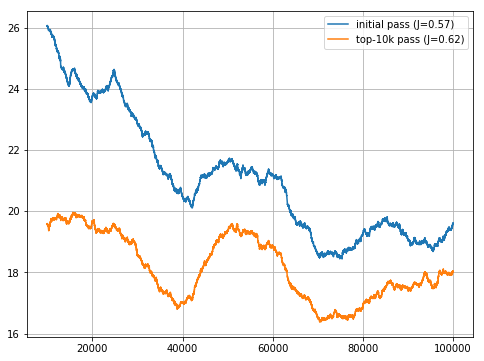

In [17]:
roll = 10000

plt.figure(figsize=(8,6))
for key in model_w_freq_loss.keys():
    plt.plot(pd.Series(model_w_freq_loss[key]).rolling(roll).mean(), 
             label='{} (J={})'.format(key, round(model_w_freq_score[key], 2)))
plt.grid()
plt.legend()

pass